In [2]:
from numba import jit
import numpy as np
import os
import pandas as pd


def trim_borders(array, top=0, bottom=0, left=0, right=0):
    if len(array.shape) != 2:
        raise ValueError("Input array must be 2D")

    return array[top : array.shape[0] - bottom, left : array.shape[1] - right]


@jit(nopython=True)
def fix_borders(grid):
    y1 = grid.shape[1] - 1

    for x1 in range(grid.shape[0]):
        grid[x1, y1] = grid[x1, y1 - 1]
        grid[x1, 0] = grid[x1, 1]
    x2 = grid.shape[0] - 1
    for y2 in range(grid.shape[1]):
        grid[x2, y2] = grid[x2 - 1, y2]
        grid[0, y2] = grid[1, y2]

    return grid


# Function to load and preprocess data
def load_data(directory, limit=-1):
    data = []
    i = 0
    for filename in os.listdir(directory):
        if limit > 0 and i == limit:
            break
        if filename.endswith(".csv"):
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath, header=None)
            data.append(
                # trim_borders(df.values, top=1, bottom=1, left=1, right=1)
                fix_borders(trim_borders(df.values, top=1, bottom=1, left=1, right=1))
            )
            if i % 50 == 0:
                print(f"Loaded {i} files")
            i += 1
    return np.array(data)


# Load data
# data = load_data("../output40")

In [15]:
def fix_data(array_of_arrays):
    expanded_arrays = []
    i = 0
    for arr in array_of_arrays:
        expanded_arrays.append(
            compress_array_by_factor(
                fix_borders(trim_borders(arr, top=1, bottom=1, left=1, right=1)), 4
            )
        )
        if i % 100 == 0:
            print(f"Fixed {i} files")
        # if i == 1001:
        #     break
        i += 1
    return np.array(expanded_arrays)

loading...
(5000, 32, 32)
float64
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.6860 - val_loss: 0.6443
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6182 - val_loss: 0.5283
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5024 - val_loss: 0.4472
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4416 - val_loss: 0.4313
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4290 - val_loss: 0.4236
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4234 - val_loss: 0.4235
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4229 - val_loss: 0.4229
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4228 - val_loss: 0.4229
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4224 - val_loss: 0.4228
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4228 - val_loss: 0.4228
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4225 - val_loss: 0.4228
Epoch 12/50
12/12 ━━━━━━━━━━━

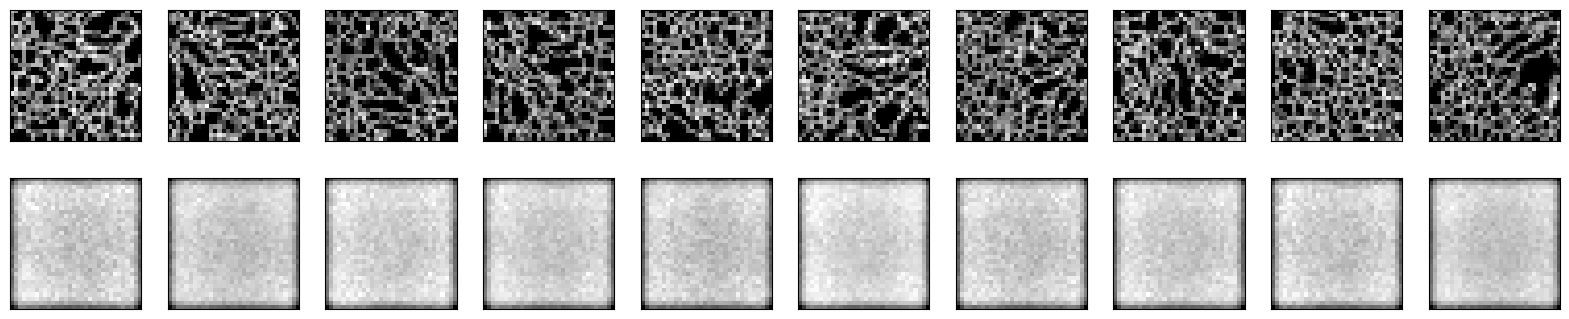

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


size = 32
true_size = size


print("loading...")

# with np.load(f"../data{size}.npz") as set:
#     data = fix_data(set["images"])

with np.load(f"../data_compressed{size}.npz") as set:
    data = set["images"]


print(data.shape)
print(data.dtype)


x_train, x_test = train_test_split(data, test_size=0.4, random_state=42)

# Flatten the images to 1D vectors
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))) / 2
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:]))) / 2


# Define the size of our encoded representations
encoding_dim = (
    8  # 32 floats -> compression factor of 24.5, assuming the input is 784 floats
)

# This is our input placeholder
input_img = Input(shape=(true_size * true_size,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation="relu")(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(true_size * true_size, activation="sigmoid")(encoded)

# This model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# This model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# Create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

# Compile the autoencoder
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

# Train the autoencoder
autoencoder.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test),
)

# Encode and decode some digits
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# Use Matplotlib to plot the original and reconstructed images
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    print(encoded_imgs[i])

    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(true_size, true_size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(true_size, true_size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Loaded 0 files


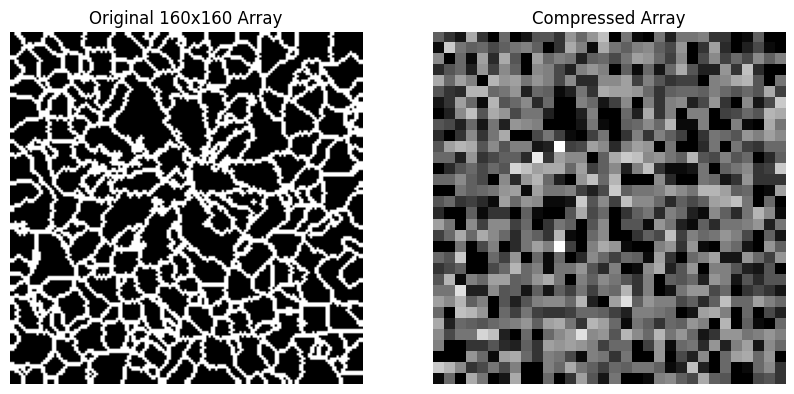

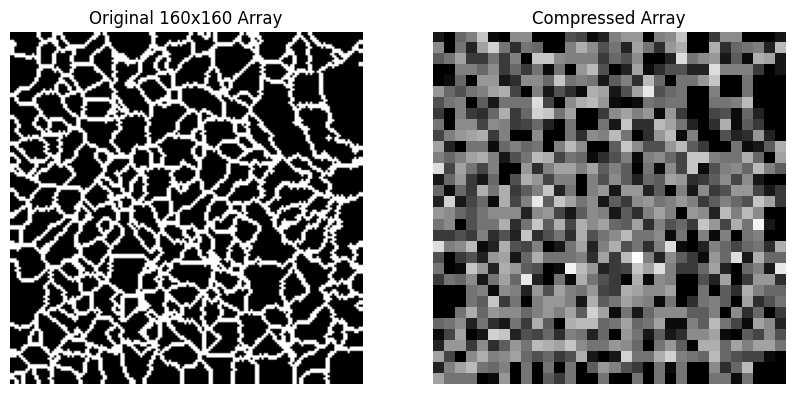

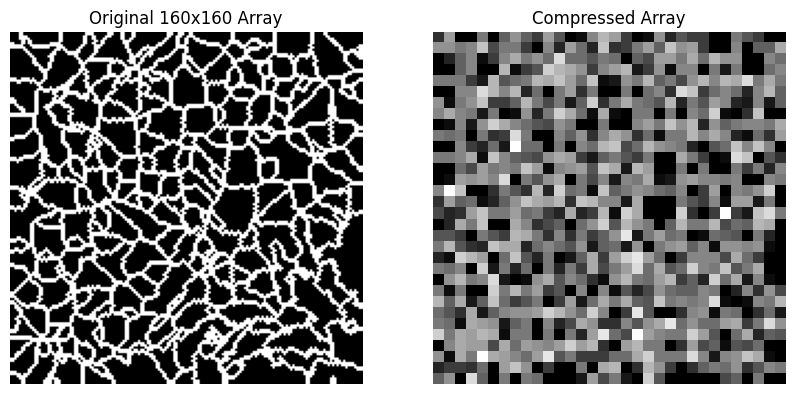

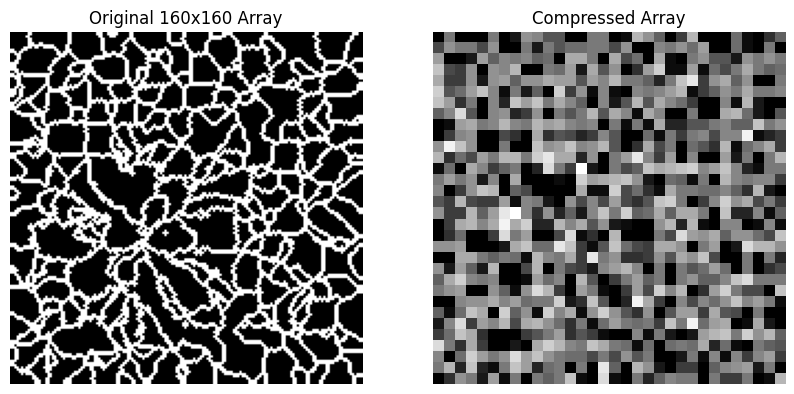

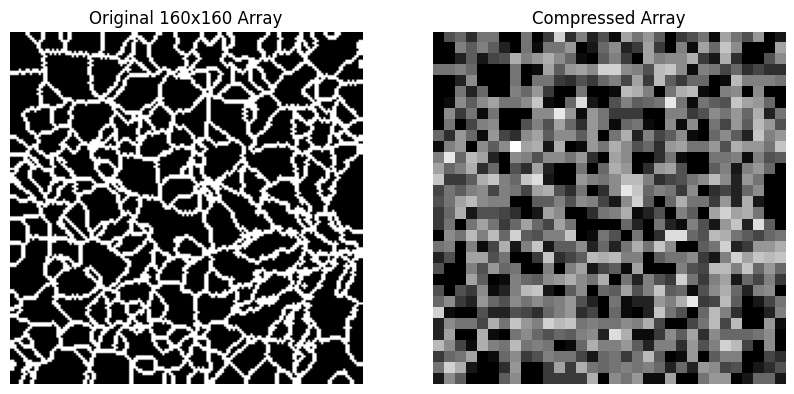

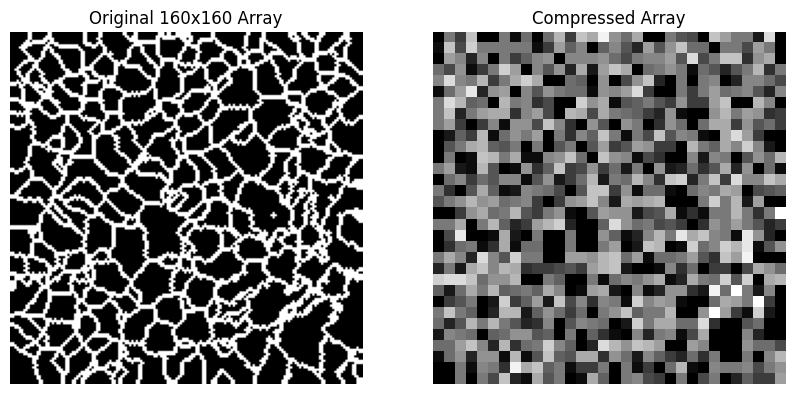

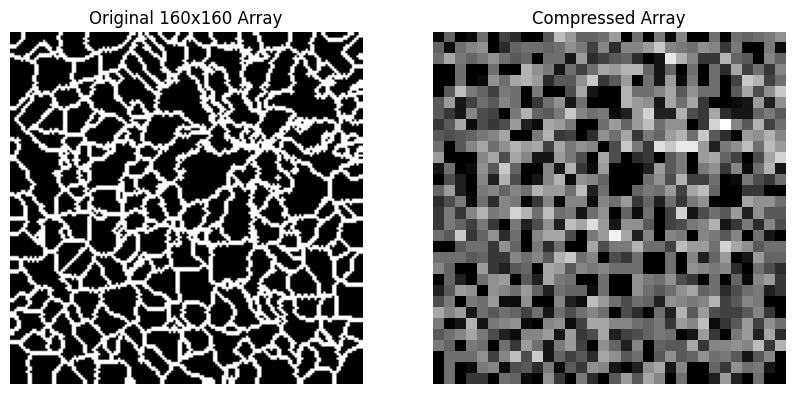

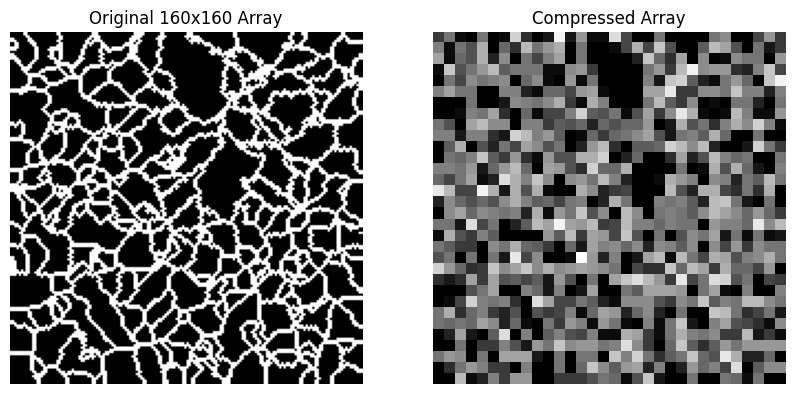

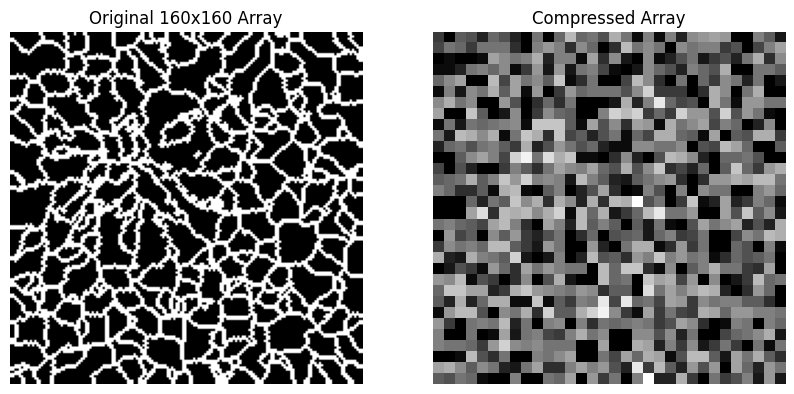

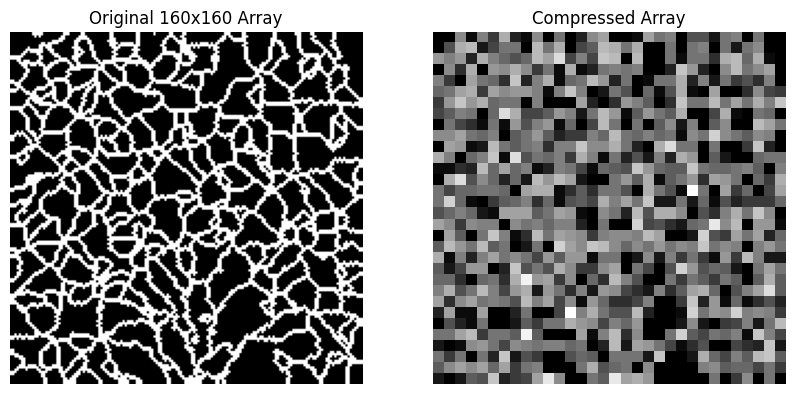

In [4]:
import numpy as np
import matplotlib.pyplot as plt


def compress_array_by_factor(original_array, factor=5):
    old_size = original_array.shape
    new_size = (old_size[0] // factor, old_size[1] // factor)

    compressed_array = np.zeros(new_size, dtype=float)

    for i in range(new_size[0]):
        for j in range(new_size[1]):
            block = original_array[
                i * factor : (i + 1) * factor, j * factor : (j + 1) * factor
            ]
            # Average the values in the block
            compressed_array[i, j] = np.mean(block)

    return compressed_array


# Example usage
original_array = np.random.randint(0, 2, (160, 160))

data = load_data("../output40", 10)

for i in range(len(data)):
    original_array = data[i]

    compressed_array = compress_array_by_factor(
        original_array, factor=5
    )  # Compressing by a factor of 5

    # Visualize the input and output
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(original_array, cmap="gray")
    axes[0].set_title("Original 160x160 Array")
    axes[0].axis("off")

    axes[1].imshow(compressed_array, cmap="gray")
    axes[1].set_title("Compressed Array")
    axes[1].axis("off")

    plt.show()
